## 1. Pendahuluan

**Reinforcement Learning (RL)** adalah paradigma machine learning dimana agent belajar melalui interaksi dengan environment.

### Perbedaan dengan ML Lainnya:

| Paradigm | Data | Learning Signal |
|----------|------|----------------|
| **Supervised** | Labeled (x, y) pairs | Correct answer |
| **Unsupervised** | Unlabeled data | Find patterns |
| **Reinforcement** | Experience (s, a, r, s') | Reward signal |

### RL Applications:
- 🎮 Game playing (AlphaGo, Atari, Chess)
- 🤖 Robotics (manipulation, locomotion)
- 🚗 Autonomous vehicles
- 📈 Trading & finance
- 🏭 Resource management
- 💊 Drug discovery
- 🗣️ Dialogue systems

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from collections import deque
import random

# Set random seed
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")

C:\Users\HP Pavilion 15\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


TensorFlow version: 2.20.0


## 2. Komponen Reinforcement Learning

### 2.1 Core Components

```
    ┌─────────────────────────────────────────────┐
    │                                             │
    │    ┌─────────┐         ┌─────────────┐     │
    │    │  Agent  │◄───────►│ Environment │     │
    │    └─────────┘         └─────────────┘     │
    │         │                     │            │
    │         │    Action (a)       │            │
    │         ├────────────────────►│            │
    │         │                     │            │
    │         │  State (s), Reward (r)           │
    │         │◄────────────────────┤            │
    │                                             │
    └─────────────────────────────────────────────┘
```

| Component | Description |
|-----------|-------------|
| **Agent** | Learner/decision maker |
| **Environment** | Everything outside agent |
| **State (s)** | Current situation |
| **Action (a)** | What agent does |
| **Reward (r)** | Feedback signal |
| **Policy (π)** | Agent's behavior/strategy |

In [2]:
# RL Loop visualization
print("""
Reinforcement Learning Loop:

At each timestep t:
1. Agent observes state sₜ
2. Agent takes action aₜ based on policy π(sₜ)
3. Environment transitions to new state sₜ₊₁
4. Environment gives reward rₜ₊₁
5. Agent learns from (sₜ, aₜ, rₜ₊₁, sₜ₊₁)
6. Repeat...

Goal: Maximize cumulative reward over time!
""")


Reinforcement Learning Loop:

At each timestep t:
1. Agent observes state sₜ
2. Agent takes action aₜ based on policy π(sₜ)
3. Environment transitions to new state sₜ₊₁
4. Environment gives reward rₜ₊₁
5. Agent learns from (sₜ, aₜ, rₜ₊₁, sₜ₊₁)
6. Repeat...

Goal: Maximize cumulative reward over time!



### 2.2 Simple Environment Example

In [3]:
# Simple GridWorld Environment
class SimpleGridWorld:
    """
    4x4 GridWorld:
    ┌───┬───┬───┬───┐
    │ S │   │   │   │
    ├───┼───┼───┼───┤
    │   │ X │   │   │  X = obstacle
    ├───┼───┼───┼───┤
    │   │   │   │   │
    ├───┼───┼───┼───┤
    │   │   │   │ G │  G = goal (+1 reward)
    └───┴───┴───┴───┘
    """
    def __init__(self):
        self.grid_size = 4
        self.start = (0, 0)
        self.goal = (3, 3)
        self.obstacle = (1, 1)
        self.state = self.start
        
        # Actions: 0=up, 1=right, 2=down, 3=left
        self.actions = {
            0: (-1, 0),  # up
            1: (0, 1),   # right
            2: (1, 0),   # down
            3: (0, -1)   # left
        }
    
    def reset(self):
        self.state = self.start
        return self.state
    
    def step(self, action):
        """Take action, return (new_state, reward, done)"""
        # Calculate new position
        dy, dx = self.actions[action]
        new_row = max(0, min(self.grid_size - 1, self.state[0] + dy))
        new_col = max(0, min(self.grid_size - 1, self.state[1] + dx))
        new_state = (new_row, new_col)
        
        # Check obstacle
        if new_state == self.obstacle:
            new_state = self.state  # Stay in place
        
        self.state = new_state
        
        # Reward
        if self.state == self.goal:
            return self.state, 1.0, True  # Goal reached!
        else:
            return self.state, -0.01, False  # Small penalty per step
    
    def render(self):
        grid = np.zeros((self.grid_size, self.grid_size), dtype=str)
        grid[:] = '.'
        grid[self.obstacle] = 'X'
        grid[self.goal] = 'G'
        grid[self.state] = 'A'
        print('\n'.join([' '.join(row) for row in grid]))
        print()

# Test environment
env = SimpleGridWorld()
state = env.reset()
print("Initial state:")
env.render()

Initial state:
A . . .
. X . .
. . . .
. . . G



In [4]:
# Random agent
env = SimpleGridWorld()
state = env.reset()
total_reward = 0
steps = 0

print("Random Agent Playing:")
for _ in range(20):
    action = np.random.randint(4)  # Random action
    next_state, reward, done = env.step(action)
    total_reward += reward
    steps += 1
    
    if done:
        print(f"\nGoal reached in {steps} steps!")
        break

print(f"Total reward: {total_reward:.2f}")
env.render()

Random Agent Playing:
Total reward: -0.20
. . . .
. X . .
. . . .
A . . G



## 3. Policy dan Value Functions

### 3.1 Policy (π)

**Policy** adalah mapping dari states ke actions.

- **Deterministic Policy**: π(s) = a
- **Stochastic Policy**: π(a|s) = P(action=a | state=s)

### 3.2 Value Functions

**State-Value Function V(s):**
$$
V^\pi(s) = \mathbb{E}_\pi \left[ \sum_{t=0}^{\infty} \gamma^t r_{t+1} \mid s_0 = s \right]
$$

Expected cumulative reward starting from state s, following policy π.

**Action-Value Function Q(s, a):**
$$
Q^\pi(s, a) = \mathbb{E}_\pi \left[ \sum_{t=0}^{\infty} \gamma^t r_{t+1} \mid s_0 = s, a_0 = a \right]
$$

Expected cumulative reward starting from state s, taking action a, then following π.

In [5]:
# Value function concepts
print("""
Value Functions:

V(s) = "How good is this state?"
       Expected future reward from state s

Q(s,a) = "How good is this action in this state?"
         Expected future reward from state s, taking action a

Relationship:
  V(s) = max_a Q(s, a)  (for optimal policy)
  V(s) = Σ_a π(a|s) × Q(s, a)  (for any policy)

Discount Factor (γ):
  - γ ∈ [0, 1]
  - γ = 0: Only care about immediate reward
  - γ = 1: Care equally about all future rewards
  - Typical: γ = 0.99
""")


Value Functions:

V(s) = "How good is this state?"
       Expected future reward from state s

Q(s,a) = "How good is this action in this state?"
         Expected future reward from state s, taking action a

Relationship:
  V(s) = max_a Q(s, a)  (for optimal policy)
  V(s) = Σ_a π(a|s) × Q(s, a)  (for any policy)

Discount Factor (γ):
  - γ ∈ [0, 1]
  - γ = 0: Only care about immediate reward
  - γ = 1: Care equally about all future rewards
  - Typical: γ = 0.99



### 3.3 Bellman Equations

**Bellman Equation** menghubungkan value function dengan successor states.

**Bellman Expectation Equation:**
$$
V^\pi(s) = \sum_a \pi(a|s) \sum_{s', r} p(s', r | s, a) [r + \gamma V^\pi(s')]
$$

**Bellman Optimality Equation:**
$$
V^*(s) = \max_a \sum_{s', r} p(s', r | s, a) [r + \gamma V^*(s')]
$$

$$
Q^*(s, a) = \sum_{s', r} p(s', r | s, a) [r + \gamma \max_{a'} Q^*(s', a')]
$$

## 4. Markov Decision Process (MDP)

**MDP** adalah mathematical framework untuk RL.

### MDP Components:
- **S**: Set of states
- **A**: Set of actions
- **P(s'|s, a)**: Transition probability
- **R(s, a, s')**: Reward function
- **γ**: Discount factor

### Markov Property:
$$
P(s_{t+1} | s_t, a_t, s_{t-1}, a_{t-1}, ...) = P(s_{t+1} | s_t, a_t)
$$

Future depends only on current state, not history!

In [6]:
# MDP example
print("""
Example MDP: Robot Navigation

States (S): {Room A, Room B, Room C, Charging Station}
Actions (A): {Move Left, Move Right, Stay, Charge}

Transition P(s'|s, a):
  - From Room A, Move Right → Room B (90%), Stay in A (10%)
  - Probabilistic due to wheel slippage

Rewards R(s, a, s'):
  - Reach Charging Station: +10
  - Each move: -1 (energy cost)
  - Stay: 0

Goal: Find optimal policy to maximize expected rewards
""")


Example MDP: Robot Navigation

States (S): {Room A, Room B, Room C, Charging Station}
Actions (A): {Move Left, Move Right, Stay, Charge}

Transition P(s'|s, a):
  - From Room A, Move Right → Room B (90%), Stay in A (10%)
  - Probabilistic due to wheel slippage

Rewards R(s, a, s'):
  - Reach Charging Station: +10
  - Each move: -1 (energy cost)
  - Stay: 0

Goal: Find optimal policy to maximize expected rewards



## 5. Q-Learning

**Q-Learning** adalah **model-free**, **off-policy** algorithm.

### Update Rule:
$$
Q(s, a) \leftarrow Q(s, a) + \alpha [r + \gamma \max_{a'} Q(s', a') - Q(s, a)]
$$

Dimana:
- α = learning rate
- γ = discount factor
- $r + \gamma \max_{a'} Q(s', a')$ = TD target
- $r + \gamma \max_{a'} Q(s', a') - Q(s, a)$ = TD error

In [7]:
# Q-Learning implementation
class QLearningAgent:
    def __init__(self, n_states, n_actions, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.n_states = n_states
        self.n_actions = n_actions
        self.alpha = alpha      # Learning rate
        self.gamma = gamma      # Discount factor
        self.epsilon = epsilon  # Exploration rate
        
        # Initialize Q-table
        self.q_table = np.zeros((n_states, n_actions))
    
    def state_to_idx(self, state):
        """Convert (row, col) to single index"""
        return state[0] * 4 + state[1]
    
    def get_action(self, state):
        """Epsilon-greedy action selection"""
        if np.random.random() < self.epsilon:
            return np.random.randint(self.n_actions)  # Explore
        else:
            state_idx = self.state_to_idx(state)
            return np.argmax(self.q_table[state_idx])  # Exploit
    
    def update(self, state, action, reward, next_state, done):
        """Q-Learning update"""
        state_idx = self.state_to_idx(state)
        next_state_idx = self.state_to_idx(next_state)
        
        # TD target
        if done:
            td_target = reward
        else:
            td_target = reward + self.gamma * np.max(self.q_table[next_state_idx])
        
        # TD error
        td_error = td_target - self.q_table[state_idx, action]
        
        # Update Q-value
        self.q_table[state_idx, action] += self.alpha * td_error

print("Q-Learning Agent created!")

Q-Learning Agent created!


In [8]:
# Train Q-Learning agent
env = SimpleGridWorld()
agent = QLearningAgent(n_states=16, n_actions=4, alpha=0.1, gamma=0.99, epsilon=0.1)

n_episodes = 1000
rewards_history = []

for episode in range(n_episodes):
    state = env.reset()
    total_reward = 0
    
    for step in range(100):  # Max steps per episode
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)
        
        agent.update(state, action, reward, next_state, done)
        
        total_reward += reward
        state = next_state
        
        if done:
            break
    
    rewards_history.append(total_reward)
    
    # Decay epsilon
    agent.epsilon = max(0.01, agent.epsilon * 0.995)

print(f"Training completed!")
print(f"Average reward (last 100 episodes): {np.mean(rewards_history[-100:]):.2f}")

Training completed!
Average reward (last 100 episodes): 0.95


Learned Policy:
→ → ↓ ↓
↓ X ↓ ↓
→ → → ↓
↓ → ↑ G


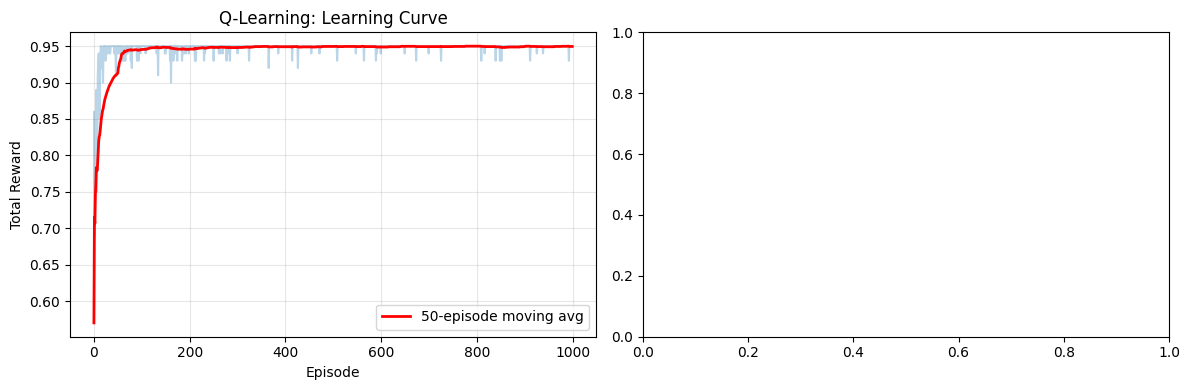

In [9]:
# Plot learning curve
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(rewards_history, alpha=0.3)
# Moving average
window = 50
moving_avg = [np.mean(rewards_history[max(0, i-window):i+1]) for i in range(len(rewards_history))]
plt.plot(moving_avg, 'r-', linewidth=2, label=f'{window}-episode moving avg')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Q-Learning: Learning Curve')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Visualize Q-table as policy
action_symbols = ['↑', '→', '↓', '←']
policy_grid = np.zeros((4, 4), dtype=object)
for i in range(4):
    for j in range(4):
        state_idx = i * 4 + j
        best_action = np.argmax(agent.q_table[state_idx])
        policy_grid[i, j] = action_symbols[best_action]

policy_grid[3, 3] = 'G'
policy_grid[1, 1] = 'X'

print("Learned Policy:")
for row in policy_grid:
    print(' '.join(row))

plt.tight_layout()
plt.show()

### 5.1 Exploration vs Exploitation

**Trade-off:**
- **Exploration**: Try new actions to discover better strategies
- **Exploitation**: Use known good actions to maximize reward

**Strategies:**
- **ε-greedy**: Random action with probability ε
- **Softmax/Boltzmann**: P(a) ∝ exp(Q(s,a)/τ)
- **UCB (Upper Confidence Bound)**: Optimism in face of uncertainty

In [10]:
# Exploration strategies
print("""
Exploration Strategies:

1. ε-greedy:
   - With prob ε: random action
   - With prob 1-ε: best action
   - Simple and effective

2. Softmax/Boltzmann:
   P(a|s) = exp(Q(s,a)/τ) / Σ exp(Q(s,a')/τ)
   - τ high → more exploration
   - τ low → more exploitation

3. Upper Confidence Bound (UCB):
   a = argmax[Q(s,a) + c√(ln(t)/N(s,a))]
   - Explores less-visited actions

4. Decaying ε:
   - Start with high ε (explore)
   - Gradually decrease (exploit)
""")


Exploration Strategies:

1. ε-greedy:
   - With prob ε: random action
   - With prob 1-ε: best action
   - Simple and effective

2. Softmax/Boltzmann:
   P(a|s) = exp(Q(s,a)/τ) / Σ exp(Q(s,a')/τ)
   - τ high → more exploration
   - τ low → more exploitation

3. Upper Confidence Bound (UCB):
   a = argmax[Q(s,a) + c√(ln(t)/N(s,a))]
   - Explores less-visited actions

4. Decaying ε:
   - Start with high ε (explore)
   - Gradually decrease (exploit)



## 6. Deep Q-Network (DQN)

**DQN** (Mnih et al., 2015) menggunakan neural network untuk approximate Q-function.

### Key Innovations:
1. **Experience Replay**: Store transitions, sample randomly
2. **Target Network**: Separate network untuk stable targets
3. **CNN for pixels**: End-to-end learning dari raw images

In [11]:
# DQN Architecture
print("""
DQN Architecture:

     State s                 Q-values for all actions
        │                              │
        ▼                              │
  ┌───────────┐                        │
  │   Input   │                        │
  │  (state)  │                        │
  └─────┬─────┘                        │
        │                              │
        ▼                              │
  ┌───────────┐                        │
  │   Dense   │                        │
  │   Layers  │                        │
  └─────┬─────┘                        │
        │                              │
        ▼                              ▼
  ┌───────────────────────────────────────┐
  │  Output: Q(s,a₁), Q(s,a₂), ..., Q(s,aₙ) │
  └───────────────────────────────────────┘

Loss = (Q(s,a) - target)²
Target = r + γ max_a' Q_target(s', a')
""")


DQN Architecture:

     State s                 Q-values for all actions
        │                              │
        ▼                              │
  ┌───────────┐                        │
  │   Input   │                        │
  │  (state)  │                        │
  └─────┬─────┘                        │
        │                              │
        ▼                              │
  ┌───────────┐                        │
  │   Dense   │                        │
  │   Layers  │                        │
  └─────┬─────┘                        │
        │                              │
        ▼                              ▼
  ┌───────────────────────────────────────┐
  │  Output: Q(s,a₁), Q(s,a₂), ..., Q(s,aₙ) │
  └───────────────────────────────────────┘

Loss = (Q(s,a) - target)²
Target = r + γ max_a' Q_target(s', a')



In [12]:
# Experience Replay Buffer
class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)
    
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (
            np.array(states),
            np.array(actions),
            np.array(rewards),
            np.array(next_states),
            np.array(dones)
        )
    
    def __len__(self):
        return len(self.buffer)

print("Replay Buffer created!")

Replay Buffer created!


In [13]:
# DQN Agent
class DQNAgent:
    def __init__(self, state_dim, n_actions, hidden_sizes=[64, 64]):
        self.state_dim = state_dim
        self.n_actions = n_actions
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.batch_size = 32
        
        # Networks
        self.q_network = self._build_network(hidden_sizes)
        self.target_network = self._build_network(hidden_sizes)
        self.update_target_network()
        
        # Optimizer
        self.optimizer = keras.optimizers.Adam(learning_rate=0.001)
        
        # Replay buffer
        self.buffer = ReplayBuffer()
    
    def _build_network(self, hidden_sizes):
        model = keras.Sequential([
            layers.Dense(hidden_sizes[0], activation='relu', input_shape=(self.state_dim,))
        ])
        for size in hidden_sizes[1:]:
            model.add(layers.Dense(size, activation='relu'))
        model.add(layers.Dense(self.n_actions))
        return model
    
    def update_target_network(self):
        """Copy weights to target network"""
        self.target_network.set_weights(self.q_network.get_weights())
    
    def get_action(self, state):
        """Epsilon-greedy action selection"""
        if np.random.random() < self.epsilon:
            return np.random.randint(self.n_actions)
        
        q_values = self.q_network.predict(state[np.newaxis], verbose=0)[0]
        return np.argmax(q_values)
    
    def train(self):
        """Train on batch from replay buffer"""
        if len(self.buffer) < self.batch_size:
            return
        
        # Sample batch
        states, actions, rewards, next_states, dones = self.buffer.sample(self.batch_size)
        
        # Compute targets
        next_q_values = self.target_network.predict(next_states, verbose=0)
        max_next_q = np.max(next_q_values, axis=1)
        targets = rewards + (1 - dones) * self.gamma * max_next_q
        
        # Train
        with tf.GradientTape() as tape:
            q_values = self.q_network(states)
            # Get Q-values for taken actions
            action_masks = tf.one_hot(actions, self.n_actions)
            q_values_for_actions = tf.reduce_sum(q_values * action_masks, axis=1)
            
            loss = tf.reduce_mean(tf.square(targets - q_values_for_actions))
        
        grads = tape.gradient(loss, self.q_network.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.q_network.trainable_variables))
        
        # Decay epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        
        return loss.numpy()

print("DQN Agent created!")

DQN Agent created!


In [14]:
# DQN Training loop (conceptual)
print("""
DQN Training Loop:

for episode in range(num_episodes):
    state = env.reset()
    
    while not done:
        # 1. Select action (ε-greedy)
        action = agent.get_action(state)
        
        # 2. Take action
        next_state, reward, done = env.step(action)
        
        # 3. Store transition
        agent.buffer.add(state, action, reward, next_state, done)
        
        # 4. Train on batch
        agent.train()
        
        state = next_state
    
    # 5. Update target network periodically
    if episode % update_freq == 0:
        agent.update_target_network()
""")


DQN Training Loop:

for episode in range(num_episodes):
    state = env.reset()
    
    while not done:
        # 1. Select action (ε-greedy)
        action = agent.get_action(state)
        
        # 2. Take action
        next_state, reward, done = env.step(action)
        
        # 3. Store transition
        agent.buffer.add(state, action, reward, next_state, done)
        
        # 4. Train on batch
        agent.train()
        
        state = next_state
    
    # 5. Update target network periodically
    if episode % update_freq == 0:
        agent.update_target_network()



### 6.1 DQN Improvements

| Improvement | Description |
|-------------|-------------|
| **Double DQN** | Reduce overestimation bias |
| **Dueling DQN** | Separate state value and advantage |
| **Prioritized Replay** | Sample important transitions more |
| **Noisy Networks** | Learned exploration |
| **Rainbow** | Combine all improvements |

In [15]:
# Double DQN concept
print("""
Double DQN:

Problem: Standard DQN overestimates Q-values
  target = r + γ max_a' Q_target(s', a')
  ↑ Same network selects AND evaluates action

Solution: Use different networks for selection and evaluation
  a* = argmax_a' Q_online(s', a')   # Online network SELECTS
  target = r + γ Q_target(s', a*)   # Target network EVALUATES

Dueling DQN:

Split Q into Value and Advantage:
  Q(s, a) = V(s) + A(s, a)
  
  V(s) = How good is this state?
  A(s, a) = How much better is action a than average?

Benefits: Better learning when actions don't matter much
""")


Double DQN:

Problem: Standard DQN overestimates Q-values
  target = r + γ max_a' Q_target(s', a')
  ↑ Same network selects AND evaluates action

Solution: Use different networks for selection and evaluation
  a* = argmax_a' Q_online(s', a')   # Online network SELECTS
  target = r + γ Q_target(s', a*)   # Target network EVALUATES

Dueling DQN:

Split Q into Value and Advantage:
  Q(s, a) = V(s) + A(s, a)
  
  V(s) = How good is this state?
  A(s, a) = How much better is action a than average?

Benefits: Better learning when actions don't matter much



## 7. Policy Gradient Methods

**Policy Gradient** methods directly optimize the policy.

### Key Idea:
Instead of learning Q-values → derive policy,
directly parameterize policy π_θ(a|s) and optimize θ.

In [16]:
# Policy Gradient vs Value-Based
print("""
Value-Based vs Policy Gradient:

Value-Based (DQN):
  - Learn Q(s, a)
  - Derive policy: π(s) = argmax_a Q(s, a)
  - Discrete actions only
  - Can be unstable

Policy Gradient (REINFORCE):
  - Directly learn π_θ(a|s)
  - Continuous actions supported
  - Smoother optimization
  - High variance

Best of both: Actor-Critic methods!
""")


Value-Based vs Policy Gradient:

Value-Based (DQN):
  - Learn Q(s, a)
  - Derive policy: π(s) = argmax_a Q(s, a)
  - Discrete actions only
  - Can be unstable

Policy Gradient (REINFORCE):
  - Directly learn π_θ(a|s)
  - Continuous actions supported
  - Smoother optimization
  - High variance

Best of both: Actor-Critic methods!



### 7.1 REINFORCE Algorithm

**Policy Gradient Theorem:**
$$
\nabla_\theta J(\theta) = \mathbb{E}_{\pi_\theta} \left[ \nabla_\theta \log \pi_\theta(a|s) \cdot G_t \right]
$$

Dimana $G_t = \sum_{k=0}^{\infty} \gamma^k r_{t+k+1}$ adalah return.

**Intuition:**
- If action led to high return → increase probability
- If action led to low return → decrease probability

In [17]:
# REINFORCE Agent
class REINFORCEAgent:
    def __init__(self, state_dim, n_actions):
        self.state_dim = state_dim
        self.n_actions = n_actions
        self.gamma = 0.99
        
        # Policy network
        self.policy = keras.Sequential([
            layers.Dense(64, activation='relu', input_shape=(state_dim,)),
            layers.Dense(64, activation='relu'),
            layers.Dense(n_actions, activation='softmax')  # Action probabilities
        ])
        
        self.optimizer = keras.optimizers.Adam(learning_rate=0.001)
        
        # Episode memory
        self.states = []
        self.actions = []
        self.rewards = []
    
    def get_action(self, state):
        """Sample action from policy"""
        probs = self.policy.predict(state[np.newaxis], verbose=0)[0]
        action = np.random.choice(self.n_actions, p=probs)
        return action
    
    def store_transition(self, state, action, reward):
        self.states.append(state)
        self.actions.append(action)
        self.rewards.append(reward)
    
    def compute_returns(self):
        """Compute discounted returns"""
        returns = []
        G = 0
        for r in reversed(self.rewards):
            G = r + self.gamma * G
            returns.insert(0, G)
        
        # Normalize returns
        returns = np.array(returns)
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)
        return returns
    
    def train(self):
        """Train on episode"""
        returns = self.compute_returns()
        states = np.array(self.states)
        actions = np.array(self.actions)
        
        with tf.GradientTape() as tape:
            # Get action probabilities
            probs = self.policy(states)
            action_masks = tf.one_hot(actions, self.n_actions)
            selected_probs = tf.reduce_sum(probs * action_masks, axis=1)
            
            # Policy gradient loss
            log_probs = tf.math.log(selected_probs + 1e-8)
            loss = -tf.reduce_mean(log_probs * returns)
        
        grads = tape.gradient(loss, self.policy.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.policy.trainable_variables))
        
        # Clear memory
        self.states = []
        self.actions = []
        self.rewards = []
        
        return loss.numpy()

print("REINFORCE Agent created!")

REINFORCE Agent created!


## 8. Actor-Critic Methods

**Actor-Critic** combines policy gradient (Actor) dan value function (Critic).

### Components:
- **Actor**: Policy π_θ(a|s) - decides which action to take
- **Critic**: Value function V_w(s) - evaluates how good the state is

### Advantage:
$$
A(s, a) = Q(s, a) - V(s) \approx r + \gamma V(s') - V(s)
$$

Use advantage instead of return to reduce variance!

In [18]:
# Actor-Critic visualization
print("""
Actor-Critic Architecture:

        State s
           │
           ▼
    ┌─────────────┐
    │   Shared    │
    │   Layers    │
    └──────┬──────┘
           │
     ┌─────┴─────┐
     │           │
     ▼           ▼
┌─────────┐ ┌─────────┐
│  Actor  │ │  Critic │
│ π(a|s)  │ │  V(s)   │
└────┬────┘ └────┬────┘
     │           │
     ▼           ▼
  Action    State Value
  Probs     Estimate

Actor loss: -log π(a|s) × Advantage
Critic loss: (V(s) - target)²
""")


Actor-Critic Architecture:

        State s
           │
           ▼
    ┌─────────────┐
    │   Shared    │
    │   Layers    │
    └──────┬──────┘
           │
     ┌─────┴─────┐
     │           │
     ▼           ▼
┌─────────┐ ┌─────────┐
│  Actor  │ │  Critic │
│ π(a|s)  │ │  V(s)   │
└────┬────┘ └────┬────┘
     │           │
     ▼           ▼
  Action    State Value
  Probs     Estimate

Actor loss: -log π(a|s) × Advantage
Critic loss: (V(s) - target)²



In [19]:
# Actor-Critic Agent
class ActorCriticAgent:
    def __init__(self, state_dim, n_actions):
        self.state_dim = state_dim
        self.n_actions = n_actions
        self.gamma = 0.99
        
        # Shared base
        inputs = keras.Input(shape=(state_dim,))
        x = layers.Dense(64, activation='relu')(inputs)
        x = layers.Dense(64, activation='relu')(x)
        
        # Actor head
        actor_output = layers.Dense(n_actions, activation='softmax')(x)
        
        # Critic head
        critic_output = layers.Dense(1)(x)
        
        self.model = keras.Model(inputs=inputs, outputs=[actor_output, critic_output])
        self.optimizer = keras.optimizers.Adam(learning_rate=0.001)
    
    def get_action(self, state):
        """Sample action from policy"""
        probs, _ = self.model.predict(state[np.newaxis], verbose=0)
        action = np.random.choice(self.n_actions, p=probs[0])
        return action
    
    def train_step(self, state, action, reward, next_state, done):
        """Single training step"""
        with tf.GradientTape() as tape:
            # Forward pass
            probs, value = self.model(state[np.newaxis])
            _, next_value = self.model(next_state[np.newaxis])
            
            # TD target and advantage
            if done:
                td_target = reward
            else:
                td_target = reward + self.gamma * next_value[0, 0]
            
            advantage = td_target - value[0, 0]
            
            # Actor loss
            action_prob = probs[0, action]
            actor_loss = -tf.math.log(action_prob + 1e-8) * advantage
            
            # Critic loss
            critic_loss = tf.square(td_target - value[0, 0])
            
            # Total loss
            total_loss = actor_loss + 0.5 * critic_loss
        
        grads = tape.gradient(total_loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        
        return total_loss.numpy()

print("Actor-Critic Agent created!")

Actor-Critic Agent created!


### 8.1 Advanced Actor-Critic Methods

| Algorithm | Key Innovation |
|-----------|---------------|
| **A2C** | Advantage Actor-Critic, synchronous |
| **A3C** | Asynchronous, parallel workers |
| **PPO** | Clipped objective, stable training |
| **SAC** | Soft Actor-Critic, entropy regularization |
| **TD3** | Twin Delayed DDPG, continuous actions |

In [20]:
# PPO concept
print("""
Proximal Policy Optimization (PPO):

Problem: Large policy updates can be destructive

Solution: Clip the policy ratio

r(θ) = π_θ(a|s) / π_θ_old(a|s)

L_CLIP = min(
    r(θ) × A,
    clip(r(θ), 1-ε, 1+ε) × A
)

If A > 0: Want to increase action prob, but clip at (1+ε)
If A < 0: Want to decrease action prob, but clip at (1-ε)

Benefits:
- Simple to implement
- Stable training
- Good performance
- Used in ChatGPT training (RLHF)!
""")


Proximal Policy Optimization (PPO):

Problem: Large policy updates can be destructive

Solution: Clip the policy ratio

r(θ) = π_θ(a|s) / π_θ_old(a|s)

L_CLIP = min(
    r(θ) × A,
    clip(r(θ), 1-ε, 1+ε) × A
)

If A > 0: Want to increase action prob, but clip at (1+ε)
If A < 0: Want to decrease action prob, but clip at (1-ε)

Benefits:
- Simple to implement
- Stable training
- Good performance
- Used in ChatGPT training (RLHF)!



## 9. Kesimpulan

### Key Takeaways:

1. **RL Basics:**
   - Agent learns through interaction with environment
   - Goal: maximize cumulative reward
   - Key concepts: state, action, reward, policy

2. **Value Functions:**
   - V(s): expected return from state s
   - Q(s, a): expected return from state s, action a
   - Bellman equations for recursive definition

3. **Q-Learning:**
   - Model-free, off-policy
   - Learn Q-values from experience
   - ε-greedy exploration

4. **Deep Q-Network (DQN):**
   - Neural network approximates Q-function
   - Experience replay for stable training
   - Target network for stable targets

5. **Policy Gradient:**
   - Directly optimize policy parameters
   - REINFORCE algorithm
   - Works with continuous actions

6. **Actor-Critic:**
   - Combines value-based and policy-based
   - Actor (policy) + Critic (value function)
   - PPO is state-of-the-art

### Algorithm Selection:

| Scenario | Recommended |
|----------|-------------|
| Discrete actions, small state | Q-Learning |
| Discrete actions, large/continuous state | DQN, Rainbow |
| Continuous actions | PPO, SAC, TD3 |
| Stable training needed | PPO |
| Sample efficiency critical | SAC |

In [21]:
# Summary visualization
print("""
┌─────────────────────────────────────────────────────────────────┐
│                 Reinforcement Learning Summary                   │
├─────────────────────────────────────────────────────────────────┤
│                                                                  │
│  RL Methods                                                      │
│      │                                                           │
│      ├── Value-Based                                             │
│      │       ├── Q-Learning (tabular)                           │
│      │       ├── DQN (deep)                                     │
│      │       └── Double DQN, Dueling DQN, Rainbow               │
│      │                                                           │
│      ├── Policy-Based                                            │
│      │       └── REINFORCE                                       │
│      │                                                           │
│      └── Actor-Critic                                            │
│              ├── A2C, A3C                                        │
│              ├── PPO (most popular)                              │
│              └── SAC, TD3 (continuous)                           │
│                                                                  │
├─────────────────────────────────────────────────────────────────┤
│  Key Applications:                                               │
│  • Game AI (AlphaGo, Atari, StarCraft)                          │
│  • Robotics (manipulation, locomotion)                          │
│  • LLM Training (RLHF - ChatGPT, Claude)                        │
│  • Autonomous Systems                                            │
└─────────────────────────────────────────────────────────────────┘
""")


┌─────────────────────────────────────────────────────────────────┐
│                 Reinforcement Learning Summary                   │
├─────────────────────────────────────────────────────────────────┤
│                                                                  │
│  RL Methods                                                      │
│      │                                                           │
│      ├── Value-Based                                             │
│      │       ├── Q-Learning (tabular)                           │
│      │       ├── DQN (deep)                                     │
│      │       └── Double DQN, Dueling DQN, Rainbow               │
│      │                                                           │
│      ├── Policy-Based                                            │
│      │       └── REINFORCE                                       │
│      │                                                           │
│      └── Actor-Critic               